In [496]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Datos
https://fred.stlouisfed.org/series/S4248SM144NCEN

In [497]:
df = pd.read_csv('./Alcohol_Sales.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'
df.columns = ['Sales']

In [498]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


<AxesSubplot:xlabel='DATE'>

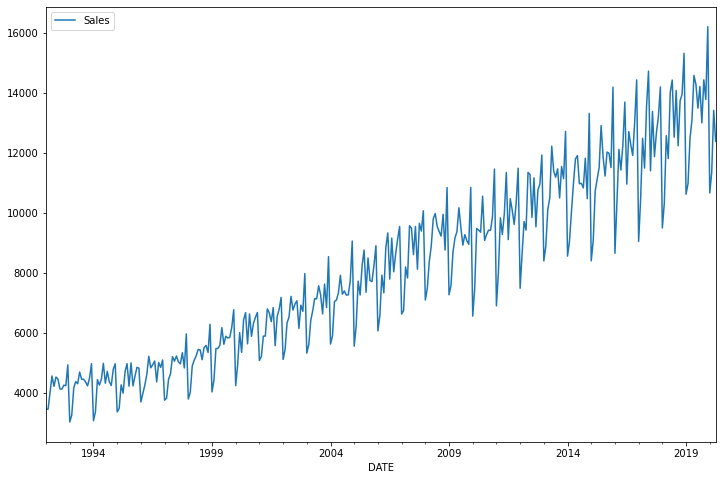

In [499]:
df.plot(figsize=(12,8))

In [500]:
from statsmodels.tsa.seasonal import seasonal_decompose

<AxesSubplot:xlabel='DATE'>

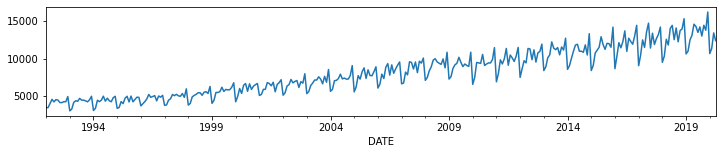

In [501]:
results = seasonal_decompose(df['Sales'])
results.observed.plot(figsize=(12,2))

<AxesSubplot:xlabel='DATE'>

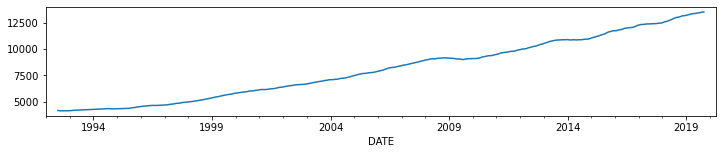

In [502]:
results.trend.plot(figsize=(12,2))

<AxesSubplot:xlabel='DATE'>

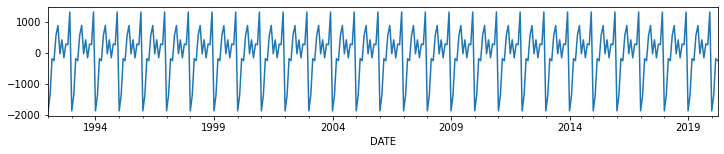

In [503]:
results.seasonal.plot(figsize=(12,2))

<AxesSubplot:xlabel='DATE'>

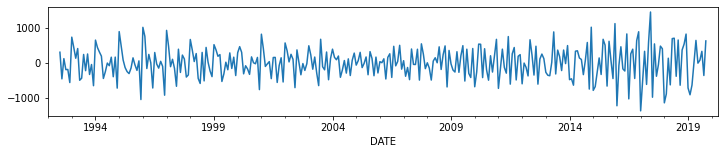

In [504]:
results.resid.plot(figsize=(12,2))

## Train Test Split

In [505]:
len(df)

340

In [506]:
len(df)-12

328

In [507]:
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

In [508]:
len(test)

12

## Escalando los datos

In [509]:
from sklearn.preprocessing import MinMaxScaler

In [510]:
scaler = MinMaxScaler()

In [511]:
scaler.fit(train)

MinMaxScaler()

In [512]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

Este generador toma una secuencia de puntos de datos (como una sereie temporal) espaciados en intervalos iguales, teniendo en cuenta otros parámetros de series temporales, para producir batches para el entrenamiento / validación.

#### Argumentos
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [513]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [515]:
# Definimos el generator
n_input = 12#entradas
n_features = 1#salida
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)#definimos los batches

In [516]:
len(scaled_train)

328

In [517]:
len(generator) # n_input = 2

316

In [518]:
scaled_train[:5]

array([[0.03486194],
       [0.03478048],
       [0.07909098],
       [0.12486764],
       [0.09692922]])

In [519]:
# ¿Cómo luce el primer batch?
generator[0]

(array([[[0.03486194],
         [0.03478048],
         [0.07909098],
         [0.12486764],
         [0.09692922],
         [0.12201678],
         [0.11688523],
         [0.09008715],
         [0.08919117],
         [0.10002444],
         [0.09847683],
         [0.1551682 ]]]),
 array([[0.]]))

In [520]:
X,y = generator[0]

In [521]:
print(f'Datos: \n{X.flatten()}')
print(f'Predicción: \n {y}')
#cada batch constara de dos datos o 2 primeros meses y la prediccion sera el tercer mes

Datos: 
[0.03486194 0.03478048 0.07909098 0.12486764 0.09692922 0.12201678
 0.11688523 0.09008715 0.08919117 0.10002444 0.09847683 0.1551682 ]
Predicción: 
 [[0.]]


### Creando el Modelo

In [525]:
from keras.models import Sequential#Modelo secuencial
from keras.layers import Dense#capa densa
from keras.layers import LSTM#capa lstm
from tensorflow.math import reduce_prod

In [526]:
# define model
#print(n_input)
model = Sequential()#creamos un modelo secuencial
#funcion de activacion relu y especificamos la dimension de entrada
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))#la primera capa que se añade sera de tipo LSTM con 100 neuronas
model.add(Dense(1))#le añadimos una capa densa que agrega todas las neuronas del LSTM a una sola prendiccion es decir una prediccion
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])#se compila utilizando como perdida el MSE y como optimizador ADAM

In [527]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [528]:
# fit model
model.fit_generator(generator,epochs=50)#una carrera completa a traves de los datos de entrenamiento

Epoch 1/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0172 - accuracy: 0.0063
Epoch 2/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0090 - accuracy: 0.0063
Epoch 3/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0076 - accuracy: 0.0063
Epoch 4/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0083 - accuracy: 0.0063
Epoch 5/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0076 - accuracy: 0.0063
Epoch 6/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0058 - accuracy: 0.0063
Epoch 7/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0047 - accuracy: 0.0063
Epoch 8/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0042 - accuracy: 0.0063
Epoch 9/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0033 - accuracy: 0.0063
Epoch 10/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0026 - accuracy: 0.0063

In [529]:
model.history.history.keys()

dict_keys(['loss', 'accuracy'])

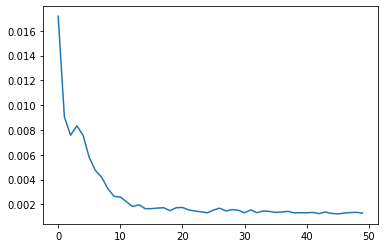

In [530]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluando en los Datos de Prueba (Test)

In [531]:
# 12 meses de historia ---> predecir el 13
# Necesitaremos los últimos 12 meses del conjunto de entrenamiento para predecir el 1er mes en el conjunto de prueba
first_eval_batch = scaled_train[-12:]

In [532]:
first_eval_batch

array([[0.89443675],
       [0.92766963],
       [0.77274578],
       [0.89940539],
       [0.74936874],
       [0.87122261],
       [0.8893052 ],
       [1.        ],
       [0.61782194],
       [0.64714507],
       [0.76899894],
       [0.8199886 ]])

In [533]:
X.shape

(1, 12, 1)

In [534]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [535]:
first_eval_batch.shape

(1, 12, 1)

In [536]:
model.predict(first_eval_batch)#el primer valor predicho

array([[0.90160155]], dtype=float32)

In [537]:
scaled_test

array([[0.94013195],
       [0.91602183],
       [0.8514295 ],
       [0.9101572 ],
       [0.81135457],
       [0.9282398 ],
       [0.87496946],
       [1.07241183],
       [0.62132443],
       [0.67760854],
       [0.84540197],
       [0.76134235]])

Ahora pongamos esta lógica en un bucle for para predecir el futuro para todo el rango de prueba.
----

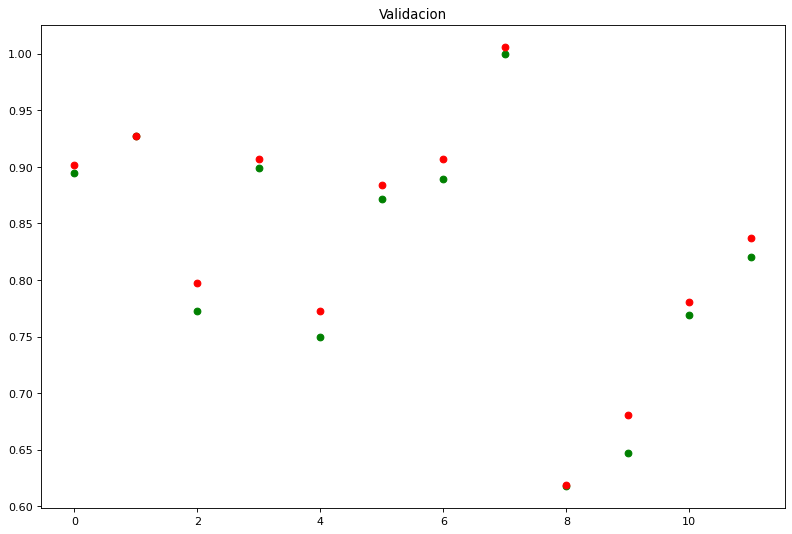

[[14175.79812658]
 [14426.9300499 ]
 [13082.39742541]
 [14255.13036644]
 [12776.46206605]
 [14055.54259241]
 [14357.29810309]
 [15453.06972682]
 [10706.19589841]
 [11753.53630638]
 [12755.9462682 ]
 [13497.56645608]
 [14243.26550889]
 [14447.33022869]
 [13313.89020681]
 [14343.39015424]
 [13021.79547381]
 [14225.00501454]
 [14532.21218359]
 [15527.08056271]
 [10851.90665245]
 [12089.83118284]
 [12907.44968367]
 [13677.58094716]]


<AxesSubplot:>

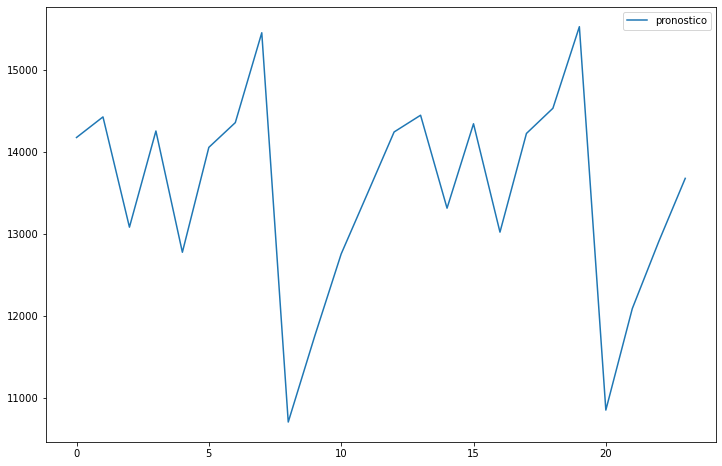

In [559]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]
    # guardar la predicción
    test_predictions.append(current_pred) 
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

#Grafico de validacion
plt.figure(figsize=(12, 8), dpi=80)
plt.scatter(range(len(first_eval_batch)),first_eval_batch,c='g')
plt.scatter(range(len(test_predictions)),test_predictions,c='r')
plt.title('Validacion')
plt.show()


#estimaciones para los proximos 12 meses
test_predictions2 = []
first_eval_batch2 = scaled_train[-n_input:]
current_batch2 = first_eval_batch2.reshape((1, n_input, n_features))
for p in range(24):
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred2 = model.predict(current_batch)[0]
    # guardar la predicción
    test_predictions2.append(current_pred2) 
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred2]],axis=1)

test_predictions2
#print(test_predictions2)
true_predictions2 = scaler.inverse_transform(test_predictions2)
print(true_predictions2)

#grafico de estimaciones para los proximos 12 meses
prediccion1SemanaDiciembre = pd.DataFrame(true_predictions2)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot(figsize=(12,8))


In [539]:
test_predictions

[array([0.90160155], dtype=float32),
 array([0.9274659], dtype=float32),
 array([0.79730856], dtype=float32),
 array([0.90692675], dtype=float32),
 array([0.7724999], dtype=float32),
 array([0.8843752], dtype=float32),
 array([0.9068252], dtype=float32),
 array([1.0059143], dtype=float32),
 array([0.61864054], dtype=float32),
 array([0.680547], dtype=float32),
 array([0.7802924], dtype=float32),
 array([0.8368107], dtype=float32)]

In [540]:
scaled_test

array([[0.94013195],
       [0.91602183],
       [0.8514295 ],
       [0.9101572 ],
       [0.81135457],
       [0.9282398 ],
       [0.87496946],
       [1.07241183],
       [0.62132443],
       [0.67760854],
       [0.84540197],
       [0.76134235]])

## Transformación inversa y Comparación

In [541]:
true_predictions = scaler.inverse_transform(test_predictions)

In [542]:
true_predictions

array([[14099.96226573],
       [14417.4990468 ],
       [12819.55724251],
       [14165.33972371],
       [12514.9815048 ],
       [13888.47450936],
       [14164.09279406],
       [15380.61023533],
       [10626.04993451],
       [11386.07550645],
       [12610.64969385],
       [13304.52506268]])

In [543]:
import matplotlib.pyplot as plt
#evaluación del modelo
model.evaluate(generator,verbose=1)

316/316 [==============================] - 1s 3ms/step - loss: 0.0012 - accuracy: 0.0063


[0.001210174523293972, 0.006329114083200693]

In [544]:
#test
test['Predictions'] = true_predictions

<ipython-input-544-f4e01b1b9de7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [545]:
test

,Sales,Predictions
DATE,,
2019-05-01,14573,14099.962266
2019-06-01,14277,14417.499047
2019-07-01,13484,12819.557243
2019-08-01,14205,14165.339724
2019-09-01,12992,12514.981505
2019-10-01,14427,13888.474509
2019-11-01,13773,14164.092794
2019-12-01,16197,15380.610235
2020-01-01,10659,10626.049935


<AxesSubplot:xlabel='DATE'>

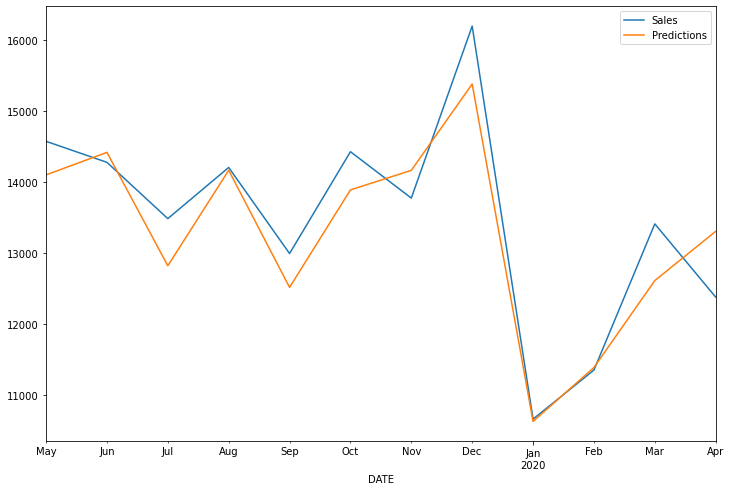

In [546]:
test.plot(figsize=(12,8))